In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz
import numpy as np


In [15]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

conda install -c anaconda python-graphviz

conda install -c anaconda pydot

In [104]:
giocatori = pd.read_csv('dataset\giocatori.csv')

giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)
giocatori = giocatori.drop('rim_d', axis = 1)
giocatori = giocatori.drop('rim_o', axis = 1)
giocatori = giocatori.drop('t1_per', axis = 1)
giocatori = giocatori.drop('t2_per', axis = 1)
giocatori = giocatori.drop('t3_per', axis = 1)

players_without_role = giocatori.loc[(giocatori["ruolo"].isnull()) | (giocatori["ruolo"] == "NaN")]
players_without_role = players_without_role.drop('ruolo', axis = 1)

giocatori = giocatori.dropna();

# Definire una funzione per scalare i valori di ogni riga
def scale_cols(df, col):
    df = df[df[col] != 0]
    factor = 40/df[col].values
    float_cols = df.select_dtypes(include=['float64']).columns
    float_cols = float_cols.drop(col)
    df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
    return df

players_without_role = scale_cols(players_without_role, 'minuti')
players_without_role = players_without_role.drop('minuti', axis = 1)
players_without_role["altezza"] = players_without_role["altezza"].replace(0, np.nan, inplace=True)

giocatori = scale_cols(giocatori, 'minuti')
giocatori = giocatori.drop('minuti', axis = 1)

C:\Users\nicol\AppData\Local\Temp\ipykernel_25988\4277839721.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
C:\Users\nicol\AppData\Local\Temp\ipykernel_25988\4277839721.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)


In [105]:
x = giocatori.drop('ruolo', axis=1)
y = giocatori['ruolo']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state=100)

In [106]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3, 5, 7, 9,11,None],
              'min_samples_split': [2, 10, 30, 50]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(x, y)
clf = grid_search.best_estimator_

print("Best parameters found: ", grid_search.best_params_)
print("Best score: %0.2f" % grid_search.best_score_)

Best parameters found:  {'max_depth': 3, 'min_samples_split': 50}
Best score: 0.67


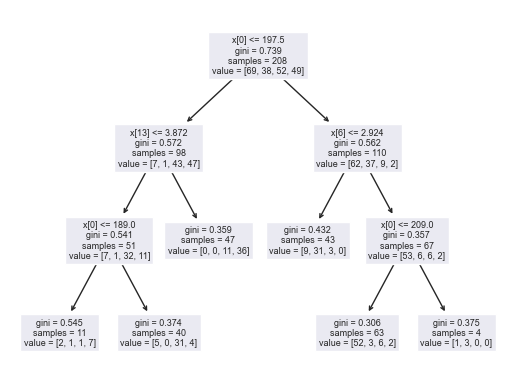

In [107]:
tree.plot_tree(clf)
plt.show()

In [108]:
#Esportazione albero di decisione
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("ruoli_tree")

'ruoli_tree.pdf'

In [109]:
#Quasto modello non può lavorare con valori nulli. Dunque si scarta in caso si abbiano giocatori con valori nulli.
#y_pred = grid_search.predict(players_without_role)
#print(players_without_role.values)
#print(y_pred)

In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn import datasets

HGBC = HistGradientBoostingClassifier(max_iter=150, learning_rate=0.1)
HGBC.fit(x, y)

scores = cross_val_score(HGBC, x, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.62 (+/- 0.14)


In [23]:
y_pred = HGBC.predict(players_without_role)
print(y_pred)

['Ala' 'Guardia' 'Ala' 'Guardia' 'Guardia' 'Ala' 'Play' 'Ala' 'Ala' 'Play'
 'Play' 'Play' 'Ala' 'Play' 'Ala' 'Play' 'Centro' 'Guardia' 'Centro'
 'Play' 'Play' 'Play' 'Guardia' 'Guardia' 'Guardia' 'Guardia' 'Play' 'Ala'
 'Ala' 'Play' 'Ala' 'Guardia']


In [24]:
import pandas as pd
import numpy as np

def convert_to_int(df):
    for col in df.columns:
        if df[col].dtype == 'float64' and not np.any(pd.isnull(df[col])):
            df[col] = df[col].astype(int)
    return df

# crea un DataFrame con valori nulli
giocatori_da_correggere = pd.read_csv('dataset\giocatori.csv')

giocatori_da_correggere = convert_to_int(giocatori_da_correggere)
# crea un array con i valori di sostituzione
y_pred = ['Ala', 'Guardia', 'Ala', 'Guardia', 'Guardia', 'Ala', 'Play', 'Ala', 'Ala', 'Play', 'Play', 'Play', 'Ala', 'Play', 'Ala', 'Play', 'Centro', 'Guardia', 'Centro', 'Play', 'Play', 'Play', 'Guardia', 'Guardia', 'Guardia', 'Guardia', 'Play', 'Ala', 'Ala', 'Play', 'Ala', 'Guardia']

i = 0
for index, row in giocatori_da_correggere.iterrows():
    if pd.isnull(row['ruolo']):
        if i < len(y_pred):
            giocatori_da_correggere.at[index, 'ruolo'] = y_pred[i]
            i += 1
            if i == len(y_pred)-1:
                i=0
        else:
            giocatori_da_correggere.at[index, 'ruolo'] = np.nan
giocatori_da_correggere.fillna(0, inplace=True)
giocatori_da_correggere.to_csv('dataset\giocatori_corretti.csv', index=False)

# stampa il DataFrame per vedere i risultati
print(giocatori_da_correggere)


                 nome_giocatore  numero_giocatore                     squadra  \
0             abass_awudu_abass              55.0    virtus_segafredo_bologna   
1    muhammad_ali_abdur_rahkman               5.0  carpegna_prosciutto_pesaro   
2           dimitrios_agravanis               0.0          gevi_napoli_basket   
3                  nicola_akele              45.0             germani_brescia   
4                 davide_alviti              40.0   ea7_emporio_armani_milano   
..                          ...               ...                         ...   
244          alessandro_zanelli               6.0  nutribullet_treviso_basket   
245            lorenzo_zangheri              11.0   dolomiti_energia_trentino   
246              simone_zanotti              41.0          gevi_napoli_basket   
247               andrea_zerini               0.0          gevi_napoli_basket   
248                wei_lun_zhao              11.0         openjobmetis_varese   

       ruolo  altezza  minu

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

# Define a range of values to test for max_depth
max_depth_values = [2, 4, 6, 8, 10]

# Define a range of values to test for random_state
random_state_values = [0, 4, 16, 64, 256, 1024,4096]

# Store the mean cross-validation scores for each combination of max_depth and random_state
scores = []
for max_depth in max_depth_values:
    for random_state in random_state_values:
        RFC = RandomForestClassifier(max_depth=max_depth, random_state=random_state)
        cv_scores = cross_val_score(RFC, x, y, cv=5)
        scores.append((max_depth, random_state, cv_scores.mean()))

# Convert the scores list to a numpy array
scores = np.array(scores)

# Get the index of the maximum score
best_index = np.argmax(scores[:,2])

# Get the best max_depth and random_state values
best_max_depth = scores[best_index, 0]
best_random_state = scores[best_index, 1]

# Print the best max_depth and random_state values
print("Best max_depth value: {}".format(best_max_depth))
print("Best random_state value: {}".format(best_random_state))

RFC = RandomForestClassifier(max_depth=int(best_max_depth), random_state=int(best_random_state))
RFC.fit(x, y)
scores = cross_val_score(RFC, x, y, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f} +/- {:.2f}".format(scores.mean(), scores.std()))

Best max_depth value: 2.0
Best random_state value: 256.0
Cross-validation scores: [0.73809524 0.73809524 0.80952381 0.65853659 0.58536585]
Average cross-validation score: 0.71 +/- 0.08


In [26]:
#Non funziona con valori nulli
#y_pred = RFC.predict(players_without_role)
#print(y_pred)

In [27]:
from sklearn.metrics import accuracy_score
# Predict the labels of the test data
y_pred = RFC.predict(x_test)

# Calculate the accuracy on the test data
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 71.43%


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
#Se non scalo la x non converge.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scal = scaler.fit_transform(x)
#########
LR = LogisticRegression(max_iter=1000)
LR.fit(x_scal, y)

scores = cross_val_score(LR, x_scal, y, cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.61 (+/- 0.11)


In [29]:
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Effettua la codifica one-hot, rende y un vettore [0,0,0,0]
le = LabelEncoder()
y = le.fit_transform(y)
Y = to_categorical(y)

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

def create_model(neurons_first_layer, neurons_second_layer):
    model = Sequential()
    model.add(Dense(neurons_first_layer, activation='relu', input_shape=(15,)))
    model.add(Dense(neurons_second_layer, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=32, verbose=0)

neurons_first_layer = [32, 64, 128]
neurons_second_layer = [16, 32, 64]
param_grid = dict(neurons_first_layer=neurons_first_layer, neurons_second_layer=neurons_second_layer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x, Y)

# Stampa dei risultati
print("Migliori parametri: ", grid_result.best_params_)
print("Miglior punteggio: ", grid_result.best_score_)

C:\Users\nicol\AppData\Local\Temp\ipykernel_15104\974946843.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=1000, batch_size=32, verbose=0)


Migliori parametri:  {'neurons_first_layer': 128, 'neurons_second_layer': 32}
Miglior punteggio:  0.6922183632850647


In [30]:
print('Accuratezza: %.2f' % (grid.score(x, Y)*100))
#print('Accuratezza: %.2f' % (accuracy*100))

Accuratezza: 83.17


In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
prova = imputer.fit_transform(players_without_role)
y_pred = grid.predict(players_without_role)
def predizione(pred):
    strings = ["Ala", "Play", "Centro", "Guardia"]
    return [strings[np.argmax(vector)] for vector in pred]

print(predizione(y_pred))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [112]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

import os
os.environ['OMP_NUM_THREADS'] = '1'

# Carica il dataset in un dataframe di pandas
giocatori = pd.read_csv("dataset/giocatori.csv")
giocatori = giocatori.drop('nome_giocatore', axis = 1)
giocatori = giocatori.drop('numero_giocatore', axis = 1)
giocatori = giocatori.drop('squadra', axis = 1)

def replace_role(row):
    if row['ruolo'] == 'Centro':
        return 0
    elif row['ruolo'] == 'Ala':
        return 1
    elif row['ruolo'] == 'Guardia':
        return 2
    elif row['ruolo'] == 'Play':
        return 3
    else:
        return 3

giocatori['ruolo'] = giocatori.apply(replace_role, axis=1)

# Definire una funzione per scalare i valori di ogni riga
def scale_cols(df, col):
    df = df[df[col] != 0]
    factor = 40/df[col].values
    float_cols = df.select_dtypes(include=['float64']).columns
    float_cols = float_cols.drop(col)
    df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)
    return df


from sklearn.preprocessing import MinMaxScaler

giocatori = scale_cols(giocatori, 'minuti')

# inizializza il scaler
scaler = MinMaxScaler()

# calcola i valori minimi e massimi per ogni colonna
scaler.fit(giocatori)

# normalizza i valori del dataset
giocatori = scaler.transform(giocatori)


# Seleziona le colonne che vuoi utilizzare come feature
features = ['altezza','T2_T', 'T2_PER','T3_T', 'T3_PER', 'RIM_O', 'RIM_D', 'RIM_T', 'STOP_D', 'STOP_S','ASS']

X = giocatori[features].values

# Inizializza il modello K-means con un numero di cluster definito (ad esempio, 5 cluster)
kmeans = KMeans(n_clusters=4, n_init=10)

# Fit il modello sui dati
kmeans.fit(X)

# Prevedi i cluster a cui appartengono ogni giocatore
labels = kmeans.predict(X)

from sklearn.metrics import silhouette_score

silhouette_score = silhouette_score(X, labels)
print("Silhouette Score: ", silhouette_score)

print(labels[1])

C:\Users\nicol\AppData\Local\Temp\ipykernel_25988\1252135091.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, float_cols] = df[float_cols].mul(factor, axis=0)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices